# Home Field Advantage and Team Performances In the NFL

By: Braden Sunderland, Darryl Ma, David Yuan, Zelalem Araya
## Introduction and Background Knowledge

In the NFL, the most elite professional American Football league in the world, it is natural to assume that the home teams would perform much better than the away team. This is due to many extraneous factors outside of the field, such as crowd involvement, travel and logistical considerations, and familiarity to the environment and weather conditions.
 <br>
<br>
For instance, crowd involvement during a NFL game is one of the highest in the world with an average attendance of 66,479 per game during 2019 (Gough, 2021). In conjunction, home teams need not concern themselves with the logistics of transportation, and will be more adapted to the local environmental conditions.
<br>
<br>
However, despite the natural presupposition, many prominent sport journalists  question whether playing at home has any influence on the performances in the NFL at all. For instance: Fox Sports speculating that home field barely provides favours in betting odds (Panayotovich, 2021), and The Score doubts whether home-field advantage still exists in the NFL (Cosentino, 2021).
 <br>
<br>
This report aims to examine how NFL teams perform in their home and away games using the dataset created by David Sasser on the 2010 to 2019 season (sourced from Pro Football Reference). Analysis and testing will be performed on the offensive and turnover statistics to answer the question: **Does being the home team have an effect on a team’s performance in the NFL?**


## Analysis Methods / Approach
To answer the question stated, the hypothesis testing method will be used with the following hypotheses:
<br>
 - The null hypothesis: Being the home team does not have an effect on team performance.<br>
 - The alternative hypothesis: Being the home team has an effect on team performance.

For the situation of our analysis, we will treat a specific team’s performance during a specific season as an entry in our revised dataset. 

General “team performance” can be quantified in the dataset by observing passing and rushing yards, rushing attempts, points scored, winning percentage, turnovers, and points against. We will create  “delta values” (the difference between the mean home figures and the away figures) for each of the aforementioned metrics. Afterwards, separate hypothesis tests will be conducted. For instance: 

Passing Yards Hypothesis Test : <br>
Delta_pass_yards = difference in mean passing yards in home games and mean passing yards in away games for a given team (defined as a specific team in a specific season).
 - H0: Delta_pass_yards = 0
 - Ha: Delta_pass_yards ≠ 0 <br>

Similar hypothesis tests will be conducted for each of the metrics we are using. By measuring the difference between the means of each metric, we will be able to determine whether each one is statistically significant, meaning it is likely to have an effect on team performance. 


## Data Analysis

The data set is first loaded in directly from the online database, then tidied and organized by grouping similar categorical variables into a single variable. 

In [330]:
# Load necessary packages
library(cowplot)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(gridExtra)

# Downloaded dataset from https://www.kaggle.com/davidsasser/nfl-game-stats-20102019/download
nfl_2015 <- read_csv('https://drive.google.com/u/0/uc?id=190TJIdeGAn35LYTkuLiNljLC_UdvFPI6&export=download', show_col_types=FALSE)
nfl_2016 <- read_csv('https://drive.google.com/u/0/uc?id=1MzBKQAow-lSygJzvraebnjwKTl4RIAC4&export=download', show_col_types=FALSE)
nfl_2017 <- read_csv('https://drive.google.com/u/0/uc?id=1UsXj9jItQik0UXbeCtnzQ7ES3GoZepiy&export=download', show_col_types=FALSE)
nfl_2018 <- read_csv('https://drive.google.com/u/0/uc?id=1UqvsJYxQ0NHPApWSSWKvtVguaTH2PnGl&export=download', show_col_types=FALSE)
nfl_2019 <- read_csv('https://drive.google.com/u/0/uc?id=1EVGagzG12fsneqmVTWk5SwbJqi59RoD4&export=download', show_col_types=FALSE)

In [271]:
# Tidy data
nfl_data <- rbind(nfl_2015, nfl_2016, nfl_2017, nfl_2018, nfl_2019)
nfl_data <- nfl_data %>%
    subset(select=-c(Result, Total)) %>%
    group_by(Week) 

#make R readable column names
colnames(nfl_data) <- make.names(colnames(nfl_data))

#Add a Game result column based on the home team
nfl_data <- nfl_data %>%
                mutate(gameResult = case_when(H.Score > A.Score ~ "W",
                                              H.Score < A.Score ~ "L",
                                              H.Score == A.Score ~ "T"))

#Data Preview
head(nfl_data)

Year,Week,HomeTeam,AwayTeam,H.RushAtt,H.RushYards,H.PassYards,H.Turnover,H.Score,A.RushAtt,A.RushYards,A.PassYards,A.Turnover,A.Score,gameResult
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2015,1,NWE,PIT,24,80,288,0,28,25,134,351,1,21,W
2015,1,BUF,IND,36,147,195,0,27,17,64,243,3,14,W
2015,1,CHI,GNB,33,189,225,1,23,30,133,189,0,31,L
2015,1,ARI,NOR,25,120,307,1,31,20,54,355,1,19,W
2015,1,DAL,NYG,23,80,356,3,27,24,99,189,0,26,W
2015,1,DEN,BAL,25,69,175,1,19,23,73,117,2,13,W


In [4]:
#Home team win percentage (Initial gauge on home team performance)
winP <- sum(nfl_data$gameResult == "W") / nrow(nfl_data)
winP

[1] 0.5585938

</br>

We will then calculate the "delta values" as mentioned in the analysis methods, and revise a new dataset for hypothesis testing. The "delta values" indicate the difference between the home and away statistics. Positive denotes a better performance at the teams home stadium while a negative value denotes a stronger performance at the opponents stadium. </br>

In [278]:
#delta rushing attempts#

#home rushing attempts avg
homeRushingAttAvg <- nfl_data %>%
    group_by(HomeTeam, Year) %>%
    summarize(H.RushingAttAvg=mean(H.RushAtt)) 
names(homeRushingAttAvg)[names(homeRushingAttAvg)== 'HomeTeam'] <- 'Team'

#away rushing attempts avg
awayRushingAttAvg <- nfl_data %>%
    group_by(AwayTeam, Year) %>%
    summarize(A.RushingAttAvg=mean(A.RushAtt)) 
names(awayRushingAttAvg)[names(awayRushingAttAvg)== 'AwayTeam'] <- 'Team'

#home and away rushing attempts average for each team of each year and the delta value
rushAttAvg <- merge(homeRushingAttAvg, awayRushingAttAvg, all.x=TRUE)
rushAttAvg$delta.RushingAttAvg <- rushAttAvg$H.RushingAttAvg - rushAttAvg$A.RushingAttAvg

`summarise()` has grouped output by 'HomeTeam'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'AwayTeam'. You can override using the `.groups` argument.



In [277]:
#delta rushing yards#

#home rushing avg
homeRushingAvg <- nfl_data %>%
    group_by(HomeTeam, Year) %>%
    summarize(H.RushingAvg=mean(H.RushYards)) 
names(homeRushingAvg)[names(homeRushingAvg)== 'HomeTeam'] <- 'Team'

#away rushing avg
awayRushingAvg <- nfl_data %>%
    group_by(AwayTeam, Year) %>%
    summarize(A.RushingAvg=mean(A.RushYards)) 
names(awayRushingAvg)[names(awayRushingAvg)== 'AwayTeam'] <- 'Team'

#home and away passing average for each team of each year and the delta value
rushAvg <- merge(homeRushingAvg, awayRushingAvg, all.x=TRUE)
rushAvg$delta.RushingAvg <- rushAvg$H.RushingAvg - rushAvg$A.RushingAvg

`summarise()` has grouped output by 'HomeTeam'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'AwayTeam'. You can override using the `.groups` argument.



In [276]:
#delta passing yards#

#home passing avg
homePassingAvg <- nfl_data %>%
    group_by(HomeTeam, Year) %>%
    summarize(H.PassingAvg=mean(H.PassYards)) 
names(homePassingAvg)[names(homePassingAvg)== 'HomeTeam'] <- 'Team'

#away passing avg
awayPassingAvg <- nfl_data %>%
    group_by(AwayTeam, Year) %>%
    summarize(A.PassingAvg=mean(A.PassYards)) 
names(awayPassingAvg)[names(awayPassingAvg)== 'AwayTeam'] <- 'Team'

#home and away passing average for each team of each year and the delta value
passAvg <- merge(homePassingAvg, awayPassingAvg, all.x=TRUE)
passAvg$delta.PassingAvg <- passAvg$H.PassingAvg - passAvg$A.PassingAvg

`summarise()` has grouped output by 'HomeTeam'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'AwayTeam'. You can override using the `.groups` argument.



In [275]:
#delta turnovers#

#home turnover avg
homeTurnoverAvg <- nfl_data %>%
    group_by(HomeTeam, Year) %>%
    summarize(H.TurnoverAvg=mean(H.Turnover)) 
names(homeTurnoverAvg)[names(homeTurnoverAvg)== 'HomeTeam'] <- 'Team'

#away turnover avg
awayTurnoverAvg <- nfl_data %>%
    group_by(AwayTeam, Year) %>%
    summarize(A.TurnoverAvg=mean(A.Turnover)) 
names(awayTurnoverAvg)[names(awayTurnoverAvg)== 'AwayTeam'] <- 'Team'

#home and away turnover average for each team of each year and the delta value
turnoverAvg <- merge(homeTurnoverAvg, awayTurnoverAvg, all.x=TRUE)
turnoverAvg$delta.TurnoverAvg <- turnoverAvg$H.TurnoverAvg - turnoverAvg$A.TurnoverAvg

`summarise()` has grouped output by 'HomeTeam'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'AwayTeam'. You can override using the `.groups` argument.



In [274]:
#delta scores#

#home score avg
homeScoreAvg <- nfl_data %>%
    group_by(HomeTeam, Year) %>%
    summarize(H.ScoreAvg=mean(H.Score)) 
names(homeScoreAvg)[names(homeScoreAvg)== 'HomeTeam'] <- 'Team'

#away score avg
awayScoreAvg <- nfl_data %>%
    group_by(AwayTeam, Year) %>%
    summarize(A.ScoreAvg=mean(A.Score)) 
names(awayScoreAvg)[names(awayScoreAvg)== 'AwayTeam'] <- 'Team'

#home and away score average for each team of each year and the delta value
scoreAvg <- merge(homeScoreAvg, awayScoreAvg, all.x=TRUE)
scoreAvg$delta.ScoreAvg <- scoreAvg$H.ScoreAvg - scoreAvg$A.ScoreAvg

`summarise()` has grouped output by 'HomeTeam'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'AwayTeam'. You can override using the `.groups` argument.



In [273]:
#delta win percentage#

#home win percentage
homeWin <- nfl_data %>%
    group_by(HomeTeam, Year) %>%
    summarize(H.Wins=sum(gameResult=='W'),
              H.Loss=sum(gameResult=='L'),
             H.WinP=H.Wins/sum(H.Wins, H.Loss))
names(homeWin)[names(homeWin)== 'HomeTeam'] <- 'Team'

#away win percentage
awayWin <- nfl_data %>%
    group_by(AwayTeam, Year) %>%
    summarize(A.Wins=sum(gameResult=='L'),
             A.Loss=sum(gameResult=='W'),
             A.WinP=A.Wins/sum(A.Wins, A.Loss)) 
names(awayWin)[names(awayWin)== 'AwayTeam'] <- 'Team'

#home and away win percentage for each team of each year and the delta value
win <- merge(homeWin, awayWin, all.x=TRUE)
win$delta.WinP <- win$H.WinP - win$A.WinP

`summarise()` has grouped output by 'HomeTeam'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'AwayTeam'. You can override using the `.groups` argument.



In [272]:
#Building the delta dataframe#
delta_data <- data.frame(win$Team, win$Year, rushAttAvg$delta.RushingAttAvg, rushAvg$delta.RushingAvg, 
                         passAvg$delta.PassingAvg, turnoverAvg$delta.TurnoverAvg, scoreAvg$delta.ScoreAvg, win$delta.WinP)
names(delta_data)[names(delta_data)== 'win.Team'] <- 'Team'
names(delta_data)[names(delta_data)== 'win.Year'] <- 'Year'
names(delta_data)[names(delta_data)== 'rushAttAvg.delta.RushingAttAvg'] <- 'delta.RushingAttAvg'
names(delta_data)[names(delta_data)== 'rushAvg.delta.RushingAvg'] <- 'delta.RushingAvg'
names(delta_data)[names(delta_data)== 'passAvg.delta.PassingAvg'] <- 'delta.PassingAvg'
names(delta_data)[names(delta_data)== 'turnoverAvg.delta.TurnoverAvg'] <- 'delta.TurnoverAvg'
names(delta_data)[names(delta_data)== 'scoreAvg.delta.ScoreAvg'] <- 'delta.ScoreAvg'
names(delta_data)[names(delta_data)== 'win.delta.WinP'] <- 'delta.WinP'
head(delta_data, 10)

,Team,Year,delta.RushingAttAvg,delta.RushingAvg,delta.PassingAvg,delta.TurnoverAvg,delta.ScoreAvg,delta.WinP
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ARI,2015,-5.500,-27.375,-8.375,0.000,-4.375,-0.12500000
2,ARI,2016,2.125,9.000,64.875,-0.750,-1.500,0.19642857
3,ARI,2017,2.000,9.250,29.625,-0.625,4.875,0.25000000
4,ARI,2018,-1.125,4.500,22.000,0.750,-3.625,-0.12500000
5,ARI,2019,0.000,-5.250,-4.875,0.000,-0.625,-0.08928571
6,ATL,2015,5.750,23.500,13.500,1.000,4.375,0.00000000
7,ATL,2016,1.125,8.000,29.250,-0.125,2.500,-0.12500000
8,ATL,2017,1.750,9.625,-9.250,0.000,0.875,0.00000000
9,ATL,2018,1.125,-2.625,-5.625,-1.250,7.250,0.12500000


</br>

With the revised dataset containing our "delta values", we will conduct hypothesis tests (specifically one proportion t-tests) on each of the metrics in question. </br>

In [336]:
#Creating functions to avoid repetition#
set.seed(2022)
null_model_function <- function(delta_metric) {
    null_model <- delta_data %>% 
    specify(response = delta_metric) %>% 
    hypothesise(null = "point", mu = 0) %>% 
    generate(type = "bootstrap", reps = 10000) %>% 
    calculate(stat = "mean")
    }

vis_null_model_function <- function(null_model, obs_test_stat) {
    vis_null_model <- null_model %>%
    visualize() + 
    shade_p_value(obs_stat = obs_test_stat, direction = "two-sided") +
    theme(plot.title = element_text(size = 15, face = "bold")) +
    theme(text = element_text(size = 15))
    }

p_value_function <- function(null_model, obs_test_stat) {
    p_value <- null_model %>%
    get_p_value(obs_stat = obs_test_stat, direction = "two-sided")
    cat("p-value:", p_value$p_value)
    }                

<strong>1 - Rushing Attempts Hypothesis Test: <strong><br>

Delta Rushing Average Attempts = difference in mean rushing attempts in home games and away games for a given team (defined as a specific team in a specific season).
 - $H_0$: Delta Rushing Average Attempts = 0
 - $H_A$: Delta Rushing Average Attempts ≠ 0 <br>
 
Test statistic: the sample mean $\bar{x}$

p-value: 2e-04

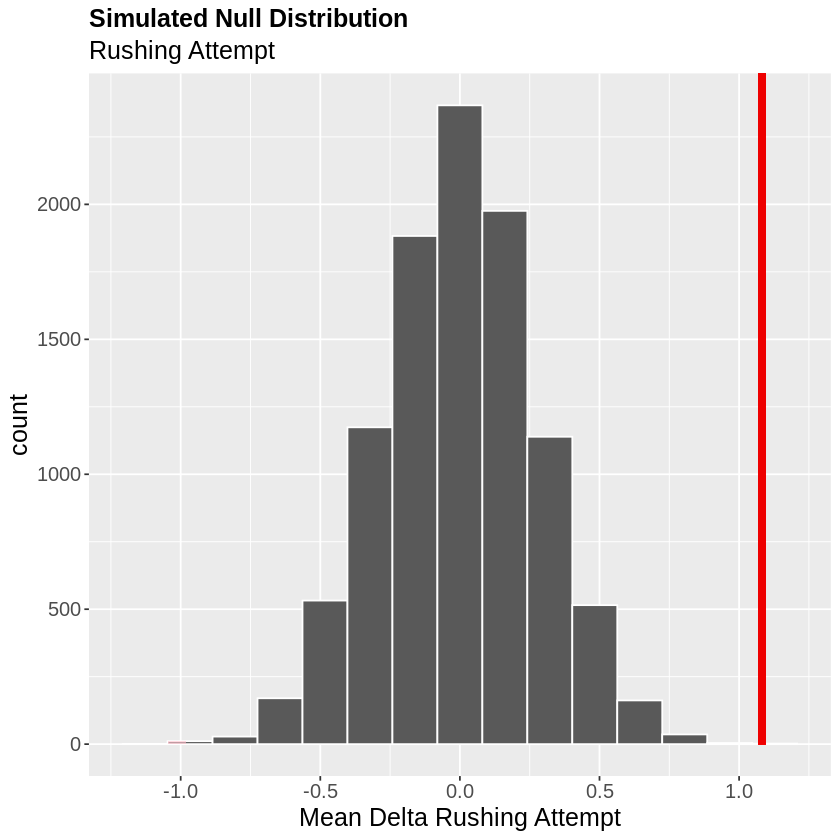

In [337]:
set.seed(2022)
#Observed test statistic
obs_test_stat_delta.RushingAttAvg <- mean(delta_data$delta.RushingAttAvg)

#Create sampling bootstrap and null model
null_model <- delta_data %>% 
    specify(response = delta.RushingAttAvg) %>% 
    hypothesise(null = "point", mu = 0) %>% 
    generate(type = "bootstrap", reps = 10000) %>% 
    calculate(stat = "mean")

#Visualizing null model
vis_null_model_delta.RushingAttAvg <- vis_null_model_function(null_model, obs_test_stat_delta.RushingAttAvg) +
    xlab("Mean Delta Rushing Attempt") + 
    ggtitle("Simulated Null Distribution", subtitle = "Rushing Attempt")
vis_null_model_delta.RushingAttAvg

#Calculate p-value
p_value_function(null_model, obs_test_stat_delta.RushingAttAvg)

p-value: 0.0002 </br>
Significance Level $\alpha$: 0.05 </br>
Decision: $H_0$ should be rejected. </br>
</br>

<strong>2 - Rushing Average Yards Hypothesis Test: <strong><br>

Delta Rushing Average Yards = difference in mean rushing yards in home games and away games for a given team (defined as a specific team in a specific season).
 - $H_0$: Delta Rushing Average Yards = 0
 - $H_A$: Delta Rushing Average Yards ≠ 0 <br>
 
Test statistic: the sample mean $\bar{x}$

p-value: 4e-04

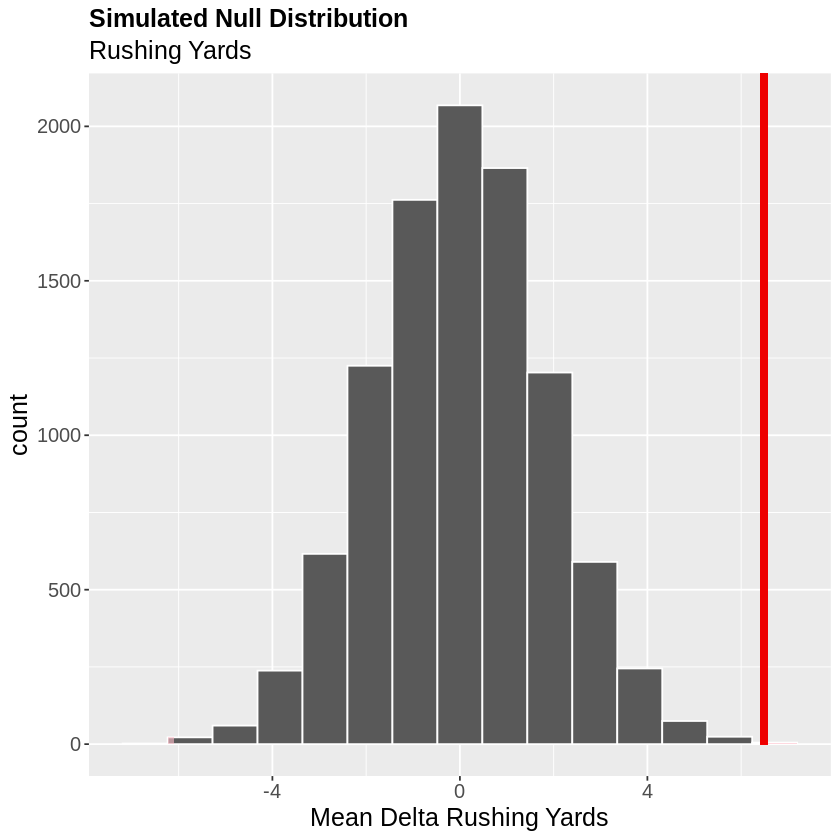

In [338]:
set.seed(2022)
#Observed test statistic
obs_test_stat_delta.RushingAvg <- mean(delta_data$delta.RushingAvg)

#Create sampling bootstrap and null model
null_model <- delta_data %>% 
    specify(response = delta.RushingAvg) %>% 
    hypothesise(null = "point", mu = 0) %>% 
    generate(type = "bootstrap", reps = 10000) %>% 
    calculate(stat = "mean")

#Visualizing null model
vis_null_model_delta.RushingAvg <- vis_null_model_function(null_model, obs_test_stat_delta.RushingAvg) +
    xlab("Mean Delta Rushing Yards") + 
    ggtitle("Simulated Null Distribution", subtitle = "Rushing Yards")
vis_null_model_delta.RushingAvg

#Calculate p-value
p_value_function(null_model, obs_test_stat_delta.RushingAvg)

p-value: 0.0004 </br>
Significance Level $\alpha$: 0.05 </br>
Decision: $H_0$ should be rejected. </br>
</br>

<strong>3 - Passing Average Yards Hypothesis Test: <strong><br>

Delta Passing Average Yards = difference in mean passing yards in home games and away games for a given team (defined as a specific team in a specific season).
 - $H_0$: Delta Passing Average Yards = 0
 - $H_A$: Delta Passing Average Yards ≠ 0 <br>
 
Test statistic: the sample mean $\bar{x}$

p-value: 2e-04

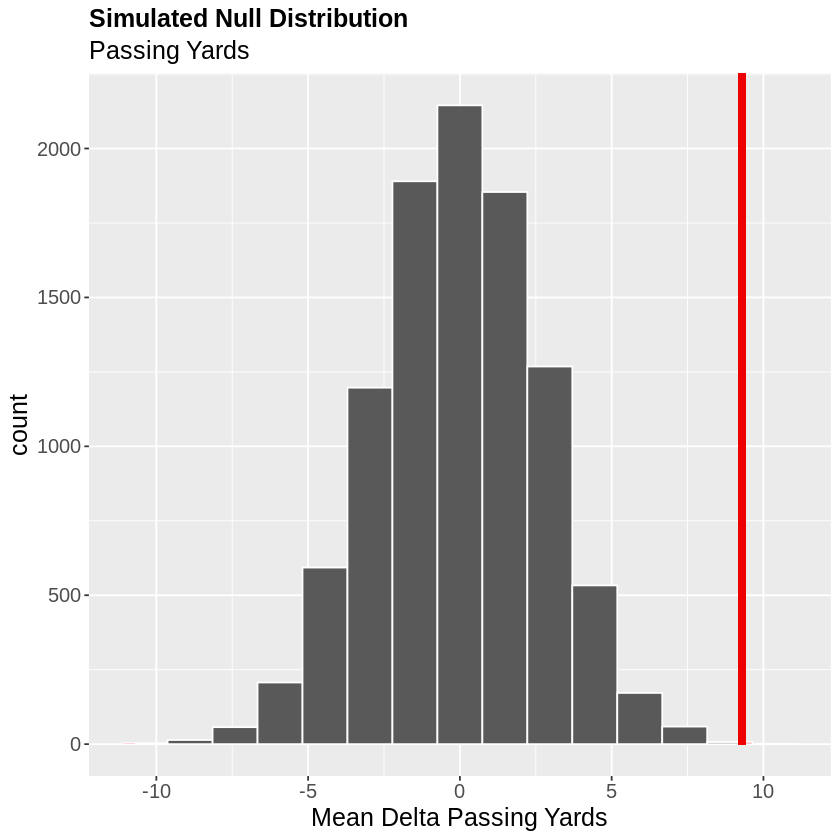

In [339]:
set.seed(2022)
#Observed test statistic
obs_test_stat_delta.PassingAvg <- mean(delta_data$delta.PassingAvg)

#Create sampling bootstrap and null model
null_model <- delta_data %>% 
    specify(response = delta.PassingAvg) %>% 
    hypothesise(null = "point", mu = 0) %>% 
    generate(type = "bootstrap", reps = 10000) %>% 
    calculate(stat = "mean")

#Visualizing null model
vis_null_model_delta.PassingAvg <- vis_null_model_function(null_model, obs_test_stat_delta.PassingAvg) +
    xlab("Mean Delta Passing Yards") + 
    ggtitle("Simulated Null Distribution", subtitle = "Passing Yards")
vis_null_model_delta.PassingAvg

#Calculate p-value
p_value_function(null_model, obs_test_stat_delta.PassingAvg)

p-value: 0.0002 </br>
Significance Level $\alpha$: 0.05 </br>
Decision: $H_0$ should be rejected. </br>
</br>

<strong>4 - Average Turnover Hypothesis Test: <strong><br>

Delta Average Turnover = difference in mean turnovers in home games and away games for a given team (defined as a specific team in a specific season).
 - $H_0$: Delta Average Turnover = 0
 - $H_A$: Delta Average Turnover ≠ 0 <br>
 
Test statistic: the sample mean $\bar{x}$

p-value: 0.8298

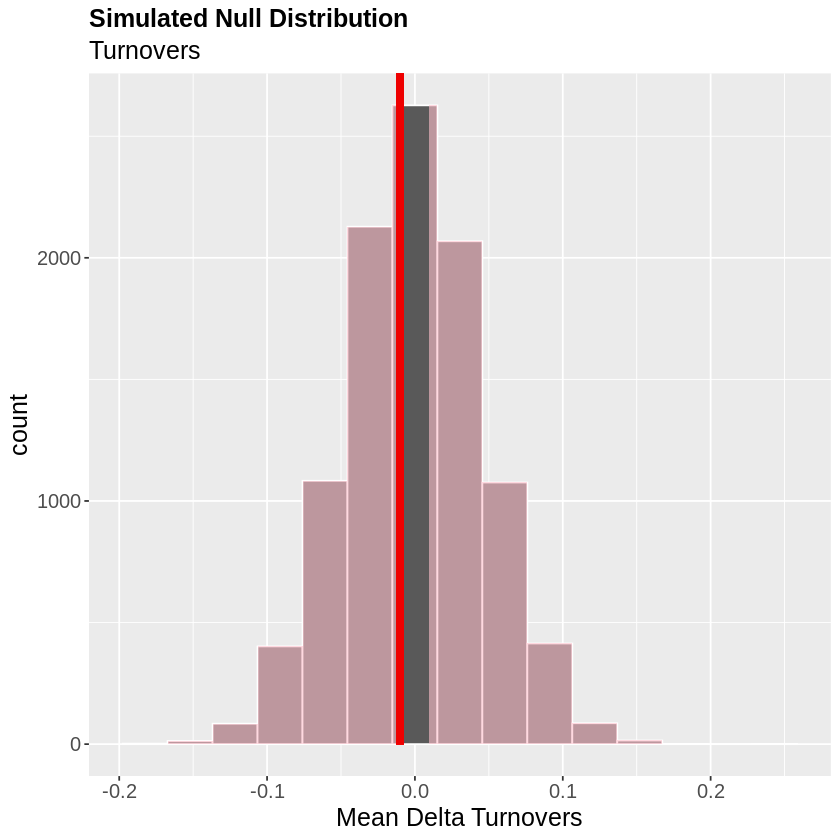

In [340]:
set.seed(2022)
#Observed test statistic
obs_test_stat_delta.TurnoverAvg <- mean(delta_data$delta.TurnoverAvg)

#Create sampling bootstrap and null model
null_model <- delta_data %>% 
    specify(response = delta.TurnoverAvg) %>% 
    hypothesise(null = "point", mu = 0) %>% 
    generate(type = "bootstrap", reps = 10000) %>% 
    calculate(stat = "mean")

#Visualizing null model
vis_null_model_delta.TurnoverAvg <- vis_null_model_function(null_model, obs_test_stat_delta.TurnoverAvg) +
    xlab("Mean Delta Turnovers") + 
    ggtitle("Simulated Null Distribution", subtitle = "Turnovers")
vis_null_model_delta.TurnoverAvg

#Calculate p-value
p_value_function(null_model, obs_test_stat_delta.TurnoverAvg)

p-value: 0.8298 </br>
Significance Level $\alpha$: 0.05 </br>
Decision: $H_0$ should not be rejected. </br>
</br>

<strong>5 - Average Scoring Hypothesis Test: <strong><br>

Delta Average Scores = difference in mean scoring differentials in home games and away games for a given team (defined as a specific team in a specific season).
 - $H_0$: Delta Average Scores = 0
 - $H_A$: Delta Average Scores ≠ 0 <br>
 
Test statistic: the sample mean $\bar{x}$

p-value: 0

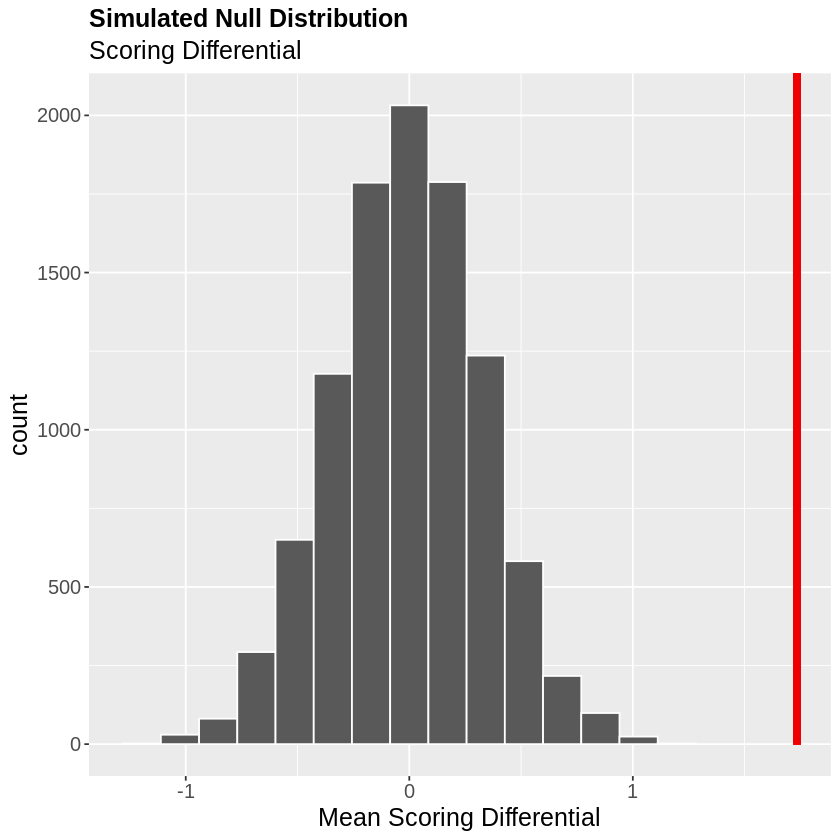

In [341]:
set.seed(2022)
#Observed test statistic
obs_test_stat_delta.ScoreAvg <- mean(delta_data$delta.ScoreAvg)

#Create sampling bootstrap and null model
null_model <- delta_data %>% 
    specify(response = delta.ScoreAvg) %>% 
    hypothesise(null = "point", mu = 0) %>% 
    generate(type = "bootstrap", reps = 10000) %>% 
    calculate(stat = "mean")

#Visualizing null model
vis_null_model_delta.ScoreAvg <- vis_null_model_function(null_model, obs_test_stat_delta.ScoreAvg) +
    xlab("Mean Scoring Differential") + 
    ggtitle("Simulated Null Distribution", subtitle = "Scoring Differential")
vis_null_model_delta.ScoreAvg

#Calculate p-value
suppressWarnings(p_value_function(null_model, obs_test_stat_delta.ScoreAvg))

p-value: 0.0000006103 </br>
Significance Level $\alpha$: 0.05 </br>
Decision: $H_0$ should be rejected. </br>
</br>

<strong>6 - Average Win Percentage Hypothesis Test: <strong><br>

Delta Average Win Percentage = difference in mean win percentage in home games and away games for a given team (defined as a specific team in a specific season).
 - $H_0$: Delta Average Win Percentage = 0
 - $H_A$: Delta Average Win Percentage ≠ 0 <br>
 
Test statistic: the sample mean $\bar{x}$

p-value: 0

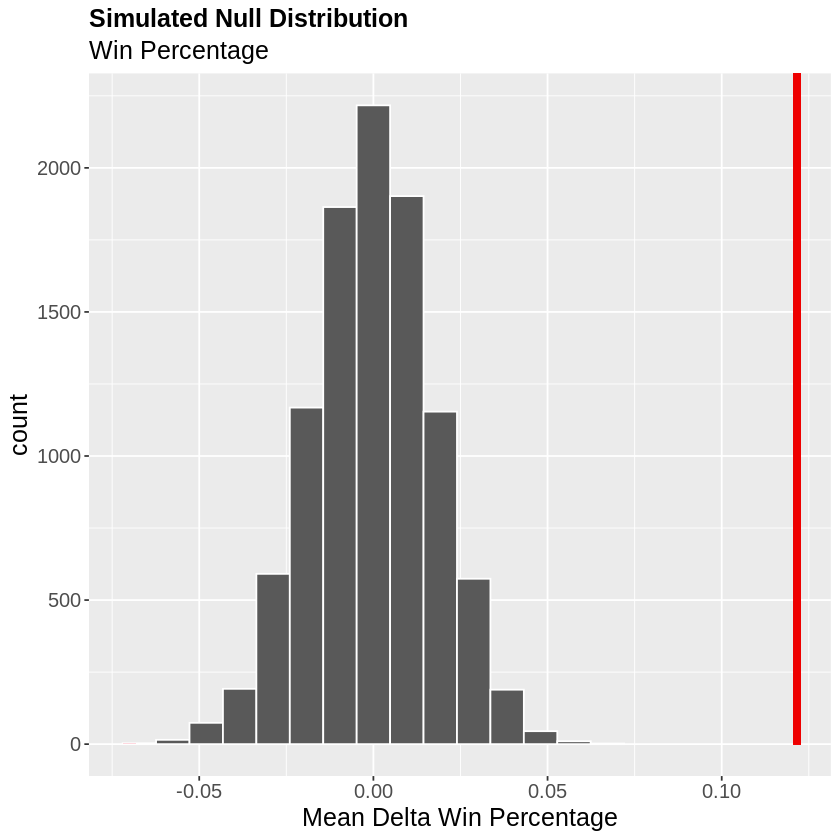

In [342]:
set.seed(2022)
#Observed test statistic
obs_test_stat_delta.WinP <- mean(delta_data$delta.WinP)

#Create sampling bootstrap and null model
null_model <- delta_data %>% 
    specify(response = delta.WinP) %>% 
    hypothesise(null = "point", mu = 0) %>% 
    generate(type = "bootstrap", reps = 10000) %>% 
    calculate(stat = "mean")

#Visualizing null model
vis_null_model_delta.WinP <- vis_null_model_function(null_model, obs_test_stat_delta.WinP) +
    xlab("Mean Delta Win Percentage") + 
    ggtitle("Simulated Null Distribution", subtitle = "Win Percentage")
vis_null_model_delta.WinP

#Calculate p-value
suppressWarnings(p_value_function(null_model, obs_test_stat_delta.WinP))

p-value: 0.00000000008154 </br>
Significance Level $\alpha$: 0.05 </br>
Decision: $H_0$ should be rejected. </br>
</br>

<strong>Hypothesis Tests Summary<strong><br>

,Rushing Attempt,Rushing Yards,Passing Yards,Turnovers,Scoring,Win Percentage
p-value,2e-04,4e-04,2e-04,0.8289,6.103e-07,8.154e-11
Decision,Reject Null,Reject Null,Reject Null,Not Reject Null,Reject Null,Reject Null


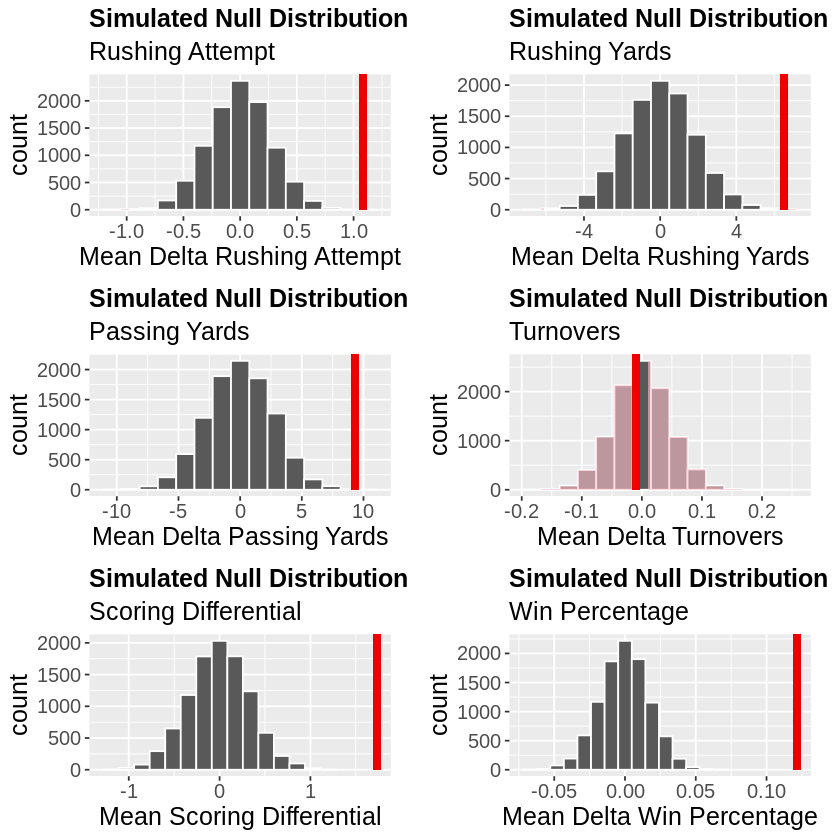

In [345]:
plot_grid(vis_null_model_delta.RushingAttAvg, NULL, vis_null_model_delta.RushingAvg, NULL, vis_null_model_delta.PassingAvg, NULL,
          vis_null_model_delta.TurnoverAvg, NULL, vis_null_model_delta.ScoreAvg, NULL, vis_null_model_delta.WinP, 
          nrow = 3, rel_widths = c(1, 0.05, 1, 0.05, 1, 0.05, 1, 0.05, 1, 0.05, 1))

summary <- matrix(c(0.0002, 0.0004, 0.0002, 0.8289, 0.0000006103, 0.00000000008154, 
                    "Reject Null", "Reject Null", "Reject Null", "Not Reject Null", "Reject Null", "Reject Null"), ncol=6, byrow=TRUE)
colnames(summary) <- c("Rushing Attempt","Rushing Yards","Passing Yards","Turnovers","Scoring","Win Percentage")
rownames(summary) <- c("p-value","Decision")
View(summary)




## Discussion

We expect home advantage to significantly affect teams’ capabilities (significantly different mean passing yards, mean rushing yards, etc.) and potentially observe home performances better than away performances.
<br>

The results of the findings could help gauge the real effects of the home field advantage in the NFL. Further conclusions could also unveil whether modern NFL teams can adapt to playing away games more effectively than the past. These results may motivate speculations on calculating betting odds and win probabilities for fantasy teams services.  


Can the result of this report be observed in other metrics that reflect team performance? <br>
Could similar findings also be observed in other professional sports? <br>
Is there a particular extraneous factor that is the primary cause of home advantage (ex. crowd participation)?


p-value: 2e-04

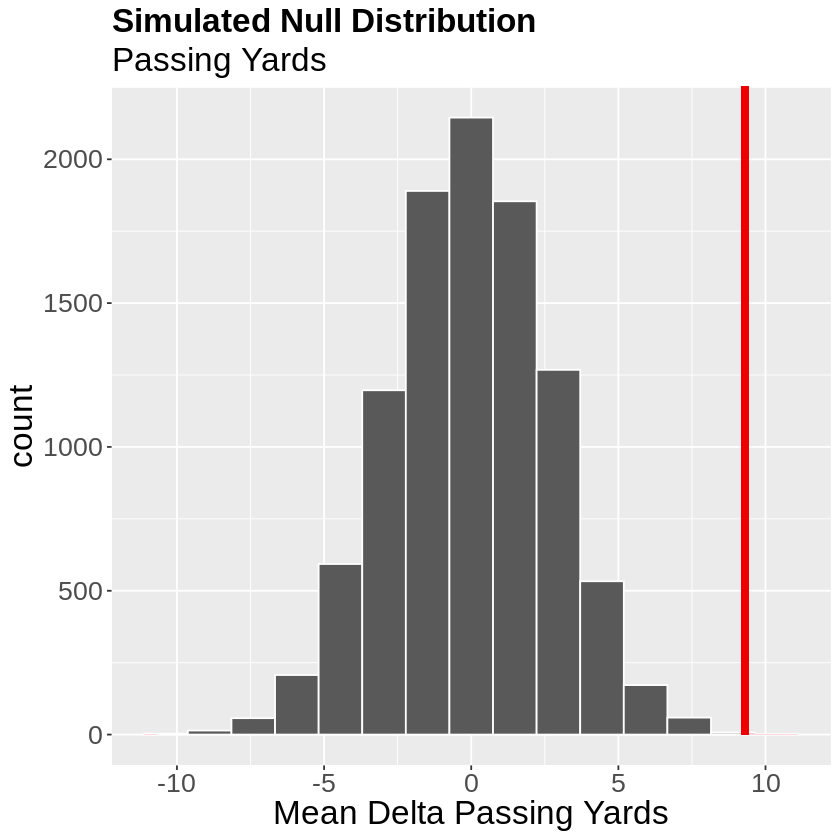

In [216]:
#backup
set.seed(2022)
#Observed test statistic
obs_test_stat_delta.PassingAvg <- mean(delta_data$delta.PassingAvg)

#Create sampling bootstrap and null model
null_model_delta.PassingAvg <- delta_data %>% 
    specify(response = delta.PassingAvg) %>% 
    hypothesise(null = "point", mu = 0) %>% 
    generate(type = "bootstrap", reps = 10000) %>% 
    calculate(stat = "mean")

#Visualizing null model
vis_null_model_delta.PassingAvg <- null_model_delta.PassingAvg %>% 
    visualize() + 
    shade_p_value(obs_stat = obs_test_stat_delta.PassingAvg, direction = "two-sided") +
    xlab("Mean Delta Passing Yards") + 
    ggtitle("Simulated Null Distribution", subtitle = "Passing Yards") +
    theme(plot.title = element_text(size = 20, face = "bold")) +
    theme(text = element_text(size = 20))
vis_null_model_delta.PassingAvg

#Calculate p-value
p_value_delta.PassingAvg <- null_model_delta.PassingAvg %>% 
    get_p_value(obs_stat = obs_test_stat_delta.PassingAvg, direction = "two-sided")
cat("p-value:", p_value_delta.PassingAvg$p_value)

## References
Cosentino, D. (2021, November 5). Does home-field advantage still exist in the NFL? theScore.com. Retrieved March 5, 2022, from https://www.thescore.com/nfl/news/2206259 <br><br>
Gough, C. (2021, March 1). U.S. major sports: Average attendance 2019. Statista. Retrieved March 5, 2022, from https://www.statista.com/statistics/207458/per-game-attendance-of-major-us-sports-leagues/ <br><br>
McGee, B. (2017, September 29). Green Bay Packers home-field advantage; Lambeau Breeds Champions in Titletown. Bleacher Report. Retrieved March 5, 2022, from https://bleacherreport.com/articles/824522-green-bay-packers-home-field-%09advantage-lambeau-breeds-champions-in-titletown <br><br>
Panayotovich, S. (2021, September 23). NFL odds: How much is home-field advantage really worth on the spread? FOX Sports. Retrieved March 5, 2022, from https://www.foxsports.com/stories/nfl/nfl-odds-how-much-home-field-advantage-worth-spread <br><br>
Sasser, D. (2021, January 25). NFL Game Stats (2010-2019). Kaggle. Retrieved March 5, 2022, from https://www.kaggle.com/davidsasser/nfl-game-stats-20102019 <br><br>